In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from preprocessing import one_hot_encode_columns

In [2]:
data_file = "data/hour.csv"
df = pd.read_csv(data_file)
df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [3]:
categorical_columns = ["season", "holiday", "weekday", "workingday", "weathersit"]
continuous_columns = ["temp", "atemp", "hum", "windspeed"]
feature_columns = categorical_columns + continuous_columns
target_columns = ["cnt"]

df = df[feature_columns + target_columns]
df.describe()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [4]:
df = one_hot_encode_columns(df, column_names=categorical_columns)
df["cnt"] = df["cnt"] / 100

In [34]:
scaler = MinMaxScaler()
scaler.fit(df["cnt"].to_numpy().reshape(-1, 1))
df["cnt"] = scaler.transform(df["cnt"].to_numpy().reshape(-1, 1))
pd.set_option("display.max_rows", None)
df.describe()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,holiday_0,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,0.193097,0.244088,0.253697,0.258703,0.243512,0.971230,...,0.142413,0.142183,0.143104,0.144542,0.317279,0.682721,0.656712,0.261465,0.081650,0.000173
std,0.192556,0.171850,0.192930,0.122340,0.185848,0.429557,0.435139,0.437935,0.429214,0.167165,...,0.349484,0.349248,0.350189,0.351649,0.465431,0.465431,0.474820,0.439445,0.273839,0.013138
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340000,0.333300,0.480000,0.104500,0.039959,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.484800,0.630000,0.194000,0.144467,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.660000,0.621200,0.780000,0.253700,0.286885,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.850700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
inputs = df.to_numpy()[:-1]
labels = df[target_columns].to_numpy()[1:]

print(f"Inputs have shape: {inputs.shape}")
print(f"Labels have shape: {labels.shape}")

Inputs have shape: (17378, 24)
Labels have shape: (17378, 1)


In [74]:
def baseline_model(vec):
    return vec[:, 4]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=9, shuffle=False)

In [76]:
X_train.shape

(13902, 24)

In [77]:
linear_regressor = LinearRegression().fit(X_train, y_train)

In [78]:
model_predictions = linear_regressor.predict(X_test)
mean_squared_error(y_test, model_predictions, squared=False)

0.12670815680052167

In [12]:
baseline_predictions = baseline_model(X_test)
mean_squared_error(y_test, baseline_predictions, squared=False)

0.1328407442645755

Text(0, 0.5, 'Prediction')

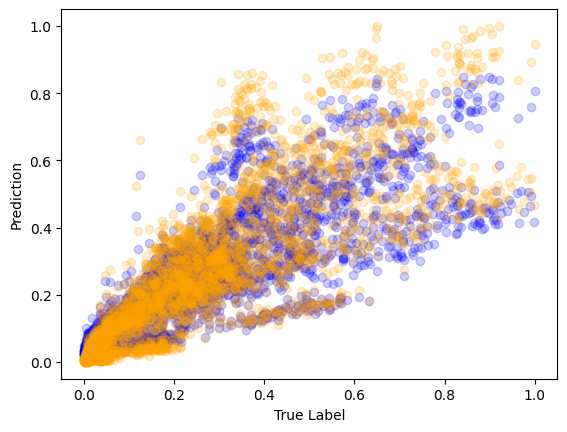

In [13]:
fig, ax = plt.subplots()

ax.scatter(y_test, model_predictions, alpha=0.2, color="blue")
ax.scatter(y_test, baseline_predictions, alpha=0.2, color="orange")
ax.set_xlabel("True Label")
ax.set_ylabel("Prediction")

In [14]:
import torch
from torch.utils.data import DataLoader

from nn_dataprep import BikeshareDataset

In [15]:
"""
shuffled_df = df.sample(frac=1, random_state=9)
train_set_size = int(len(shuffled_df) * 0.8)

train_set = shuffled_df.iloc[:train_set_size, :]
test_set = shuffled_df.iloc[train_set_size:, :]
"""

'\nshuffled_df = df.sample(frac=1, random_state=9)\ntrain_set_size = int(len(shuffled_df) * 0.8)\n\ntrain_set = shuffled_df.iloc[:train_set_size, :]\ntest_set = shuffled_df.iloc[train_set_size:, :]\n'

In [16]:
train_data = BikeshareDataset(X_train, y_train)
test_data = BikeshareDataset(X_test, y_test)

In [17]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


/home/zach/Desktop/ds4400/final-project/env/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
from torch import nn

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [21]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [22]:
learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    error = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).numpy()
            error += mean_squared_error(y.numpy(), pred, squared=False)
            
    error /= num_batches
    print(f"Test RMAE: {error}")

In [24]:
epochs = 500
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    if t % 100 == 0:
        print(t)
        test_loop(test_dataloader, model, loss_fn)
print("Done!")


0
Test RMAE: 0.2137729522856799
100
Test RMAE: 0.11851467981257222
200
Test RMAE: 0.1172655700282617
300
Test RMAE: 0.11688643721016971
400
Test RMAE: 0.11661518879912117
Done!


In [26]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info

In [27]:
import keras
from keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD

In [28]:
SEQUENCE_LENGTH_HRS = 48
SAMPLING_RATE=1
BATCH_SIZE=64
FEATURE_VEC_SIZE = 24
LEARNING_RATE=0.01

In [65]:
train_inputs = df.to_numpy()[:-SEQUENCE_LENGTH_HRS]
train_labels = df[target_columns].to_numpy()[SEQUENCE_LENGTH_HRS:]

train_set_size = 8_000

X_train = train_inputs[:train_set_size]
y_train = train_labels[:train_set_size]
X_test = train_inputs[train_set_size:]
y_test = train_labels[:train_set_size]

train_dataset = timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH_HRS,
    batch_size=BATCH_SIZE)

validation_dataset = timeseries_dataset_from_array(
    data=X_test,
    targets=y_test,
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH_HRS,
    batch_size=BATCH_SIZE)

In [66]:
a, b = next(iter(train_dataset))

In [67]:
a[0][0]

<tf.Tensor: shape=(24,), dtype=float64, numpy=
array([0.24      , 0.2879    , 0.81      , 0.        , 0.01536885,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        ])>

(8000, 24)
(9331, 24)


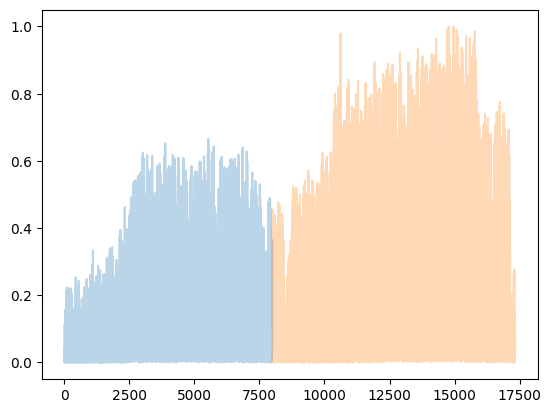

In [68]:
print(X_train.shape)
print(X_test.shape)

fig, ax = plt.subplots()

ax.plot(X_train[:, 4], alpha=0.3)
ax.plot(range(train_set_size, len(X_train) + len(X_test)), X_test[:, 4], alpha=0.3)

In [69]:
model = Sequential()
model.add(keras.Input(shape=(SEQUENCE_LENGTH_HRS, FEATURE_VEC_SIZE)))  # `None` indicates the sequence is of arbitrary length
model.add(LSTM(64))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
              loss="mean_squared_error", 
              metrics=["mae"])
model.build()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                22784     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,849
Trainable params: 22,849
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
125/125 [==============================] - 7s 39ms/step - loss: 0.0357 - mae: 0.1501 - val_loss: 0.0448 - val_mae: 0.1806
Epoch 2/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0306 - mae: 0.1393 - val_loss: 0.0321 - val_mae: 0.1542
Epoch 3/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0261 - mae: 0.1278 - val_loss: 0.0277 - val_mae: 0.1414
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0250 - mae: 0.1245 - val_loss: 0.0252 - val_mae: 0.1329
Epoch 5/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0235 - mae: 0.1210 - val_loss: 0.0232 - val_mae: 0.1256
Epoch 6/10
125/125 [==============================] - 5s 39ms/step - loss: 0.0223 - mae: 0.1170 - val_loss: 0.0231 - val_mae: 0.1249
Epoch 7/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0215 - mae: 0.1157 - val_loss: 0.0214 - val_mae: 0.1182
Epoch 8/10
125/125 [==============================] - 4s 35ms/step - 

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

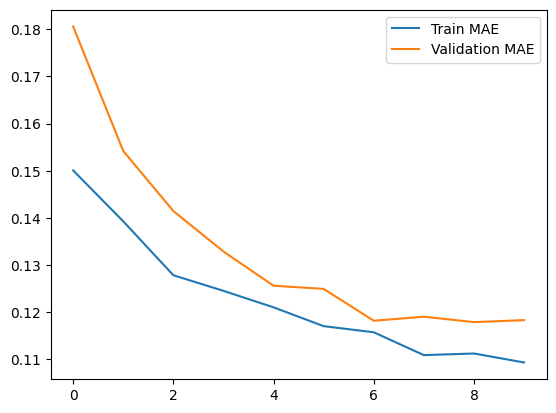

In [71]:
fig, ax = plt.subplots()

ax.plot(history.history["mae"], label="Train MAE")
ax.plot(history.history["val_mae"], label="Validation MAE")
ax.legend()
history.history.keys()